# WRIST FRACTURE DETECTION USING CONVOLUTIONAL NEURAL NETWORKS

## ARTIFICIAL INTELLIGENCE IN HEEALTHCARE
### Cletus Ngwerume & Frederick Damptey 
### Michigan Technological University

In [ ]:
# importing the necessary libraries for the project
# MURA dataset classification using TensorFlow and Keras
# This code is designed to classify images from the MURA dataset using a convolutional neural network (CNN) built with TensorFlow and Keras.
# The MURA dataset is a large dataset of musculoskeletal radiographs, and the goal is to classify these images into different categories based on the presence of abnormalities.
# The code includes data preprocessing, model building, training, and evaluation steps.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam # Legacy works better for Apple Silicon
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

#set the seed for reproducibility
seed = 55
# base url for the dataset
base = "better-mura/MURA-v1.1/"

## LOADING DATASET 

#### DATASET: LINK - https://www.kaggle.com/datasets/sudhanshusuryawanshi/better-mura

In [ ]:
# function to load the dataset
# Images are loaded from the specified directory and their labels are determined based on the presence of "positive" in the file path.
# The function returns a list of tuples containing the image paths and their corresponding labels.
# The function also checks if the image files exist before adding them to the list.
# If an image file does not exist, a message is printed to indicate the missing file.
# The function only loads wrist images (XR_WRIST) from the dataset.

def get_data(df):
    data = []

    # only loading wrist images
    for index, row in df.iterrows():
        # wrist images
        if "XR_WRIST" in row['path']:
            image_path = os.path.join(base, row['path'])
            label = 1 if "positive" in row['path'] else 0
            # check if the image file exists before adding it to the list
            if os.path.exists(image_path):
                data.append((image_path, label))
            else:
                print(f"Image not found: {image_path}")
    return data


Total images: 224045
Total wrist images: 59171


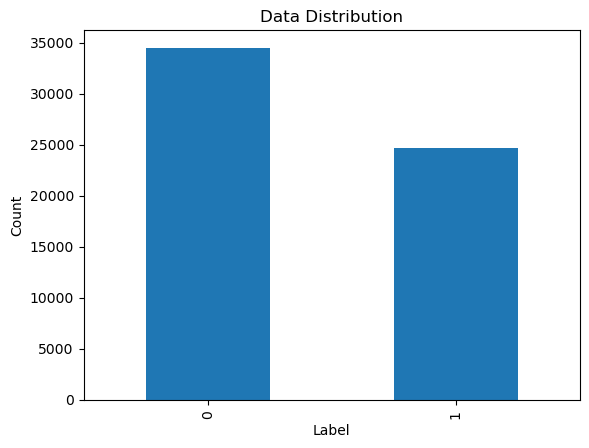

label
0    34508
1    24663
Name: count, dtype: int64


In [ ]:
# Merging CSV files
df1 = pd.read_csv(f"{base}/MURA-v1.1/train_augmented.csv")
df2 = pd.read_csv(f"{base}/MURA-v1.1/valid.csv")

# Merge DataFrames and drop NaN values
df = pd.concat([df1, df2], ignore_index=True).dropna()
print(f"Total images: {len(df)}")

# get data
data = get_data(df)
print(f"Total wrist images: {len(data)}")
data = pd.DataFrame(data, columns=["path", "label"])
data.head()
# data distribution in terms of positive and negative samples using bar plot
data['label'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print(data['label'].value_counts())


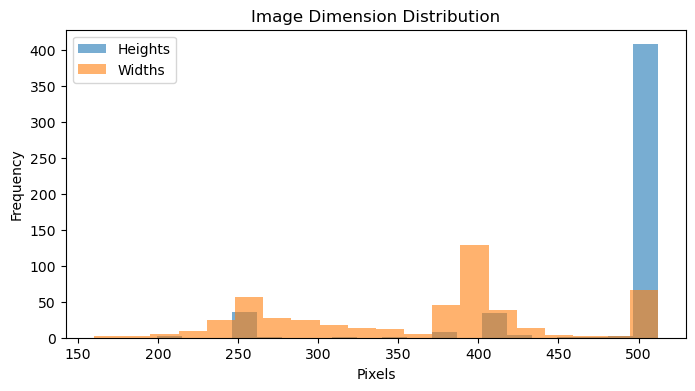

In [ ]:
# Showing the distribution of image dimensions before any preprocessing
heights = []
widths = []

for path in data['path'].sample(500):  # Sample for speed
    img = cv2.imread(path)
    h, w, _ = img.shape
    heights.append(h)
    widths.append(w)

plt.figure(figsize=(8, 4))
plt.hist(heights, bins=20, alpha=0.6, label='Heights')
plt.hist(widths, bins=20, alpha=0.6, label='Widths')
plt.title('Image Dimension Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Splitting Data for model input

In [10]:
# split all dataset 10% test and 90% train and validation
# stratified splitting
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=seed)
# split the train set into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=seed)
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Train set: 42602
Validation set: 4734
Test set: 11835


### Data argumentation

In [ ]:
# Define image data generator with augmentation
generator = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    brightness_range=(0.5, 1.5),
    validation_split=0.2  # Splitting within the generator itself
)

# Common parameters for train and validation generators
common_params = {
    "dataframe": train_df,
    "x_col": "path",
    "y_col": "label",
    "target_size": (224, 224),
    "color_mode": "rgb",
    "class_mode": "raw",
    "batch_size": 64,
    "shuffle": True,
    "seed": seed,
}

# Create=ing train and validation generators
train_images = generator.flow_from_dataframe(**common_params, subset="training")
val_images = generator.flow_from_dataframe(**common_params, subset="validation")

# Test generator (no data augmentation, no shuffling) thats why we use ImageDataGenerator() without any parameters
test_images = ImageDataGenerator().flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32,
    shuffle=False
)


Found 42603 validated image filenames.
Found 10650 validated image filenames.
Found 5918 validated image filenames.


### Model Training

In [ ]:
# Callbacks for early stopping and learning rate reduction
# EarlyStopping monitors the validation loss and stops training if it doesn't improve for a specified number of epochs (patience).
# ReduceLROnPlateau reduces the learning rate when a metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
callbacks = [early_stop, lr_schedule]

# Class weights (adjusted if fracture class is underrepresented)
class_weights = {0: 1.0, 1: 1.5}

# Common hyperparameters
dense_units = 64
dropout_rate = 0.3
learning_rate = 1e-4
epochs = 25

# --- ResNet50 Model ---
resnet_base = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze last 15 layers for fine-tuning
for layer in resnet_base.layers[:-15]:
    layer.trainable = False

x = Dense(dense_units, activation='relu')(resnet_base.output)
x = Dropout(dropout_rate)(x)
resnet_output = Dense(1, activation='sigmoid')(x)

resnet_model = tf.keras.Model(inputs=resnet_base.input, outputs=resnet_output)

resnet_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training ResNet50...")
history_resnet = resnet_model.fit(
    train_images,
    validation_data=val_images,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

# --- EfficientNetB0 Model ---
effnet_base = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze last 15 layers for fine-tuning
for layer in effnet_base.layers[:-15]:
    layer.trainable = False

x = Dense(dense_units, activation='relu')(effnet_base.output)
x = Dropout(dropout_rate)(x)
effnet_output = Dense(1, activation='sigmoid')(x)

effnet_model = tf.keras.Model(inputs=effnet_base.input, outputs=effnet_output)

effnet_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training EfficientNetB0...")
history_effnet = effnet_model.fit(
    train_images,
    validation_data=val_images,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Training ResNet50...
Epoch 1/25


2025-04-15 16:21:33.751222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


666/666 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.7593

2025-04-15 16:29:43.916915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


666/666 [==============================] - 630s 939ms/step - loss: 0.6066 - accuracy: 0.7593 - val_loss: 0.4016 - val_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 2/25
666/666 [==============================] - 729s 1s/step - loss: 0.5153 - accuracy: 0.8053 - val_loss: 0.3776 - val_accuracy: 0.8272 - lr: 1.0000e-04
Epoch 3/25
666/666 [==============================] - 739s 1s/step - loss: 0.4591 - accuracy: 0.8303 - val_loss: 0.3345 - val_accuracy: 0.8520 - lr: 1.0000e-04
Epoch 4/25
666/666 [==============================] - 639s 959ms/step - loss: 0.4068 - accuracy: 0.8499 - val_loss: 0.3982 - val_accuracy: 0.8126 - lr: 1.0000e-04
Epoch 5/25
666/666 [==============================] - 630s 945ms/step - loss: 0.3570 - accuracy: 0.8703 - val_loss: 0.3630 - val_accuracy: 0.8474 - lr: 1.0000e-04
Epoch 6/25
666/666 [==============================] - 1336s 2s/step - loss: 0.2666 - accuracy: 0.9059 - val_loss: 0.2609 - val_accuracy: 0.8858 - lr: 2.0000e-05
Epoch 7/25
666/666 [=====================

2025-04-15 22:04:31.671726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


666/666 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.7440

2025-04-15 22:13:10.821425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


666/666 [==============================] - 647s 964ms/step - loss: 0.6077 - accuracy: 0.7440 - val_loss: 0.4337 - val_accuracy: 0.7931 - lr: 1.0000e-04
Epoch 2/25
666/666 [==============================] - 601s 902ms/step - loss: 0.5281 - accuracy: 0.7939 - val_loss: 0.4109 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 3/25
666/666 [==============================] - 604s 906ms/step - loss: 0.4995 - accuracy: 0.8096 - val_loss: 0.3748 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/25
666/666 [==============================] - 585s 877ms/step - loss: 0.4784 - accuracy: 0.8178 - val_loss: 0.3736 - val_accuracy: 0.8322 - lr: 1.0000e-04
Epoch 5/25
666/666 [==============================] - 700s 1s/step - loss: 0.4577 - accuracy: 0.8294 - val_loss: 0.3584 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 6/25
666/666 [==============================] - 632s 948ms/step - loss: 0.4369 - accuracy: 0.8361 - val_loss: 0.3453 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 7/25
666/666 [================

### Evaluation


185/185 [==============================] - 24s 132ms/step

Classification Report for ResNet50:
              precision    recall  f1-score   support

    Negative       0.91      0.96      0.93      3451
    Positive       0.93      0.87      0.90      2467

    accuracy                           0.92      5918
   macro avg       0.92      0.91      0.92      5918
weighted avg       0.92      0.92      0.92      5918


Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

    Negative       0.87      0.93      0.90      3451
    Positive       0.90      0.81      0.85      2467

    accuracy                           0.88      5918
   macro avg       0.88      0.87      0.88      5918
weighted avg       0.88      0.88      0.88      5918

ResNet50 ROC AUC Score: 0.9146
EfficientNetB0 ROC AUC Score: 0.8707


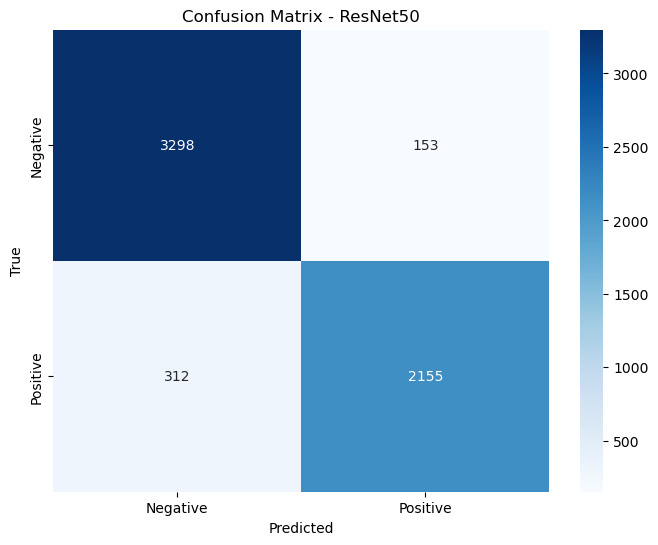

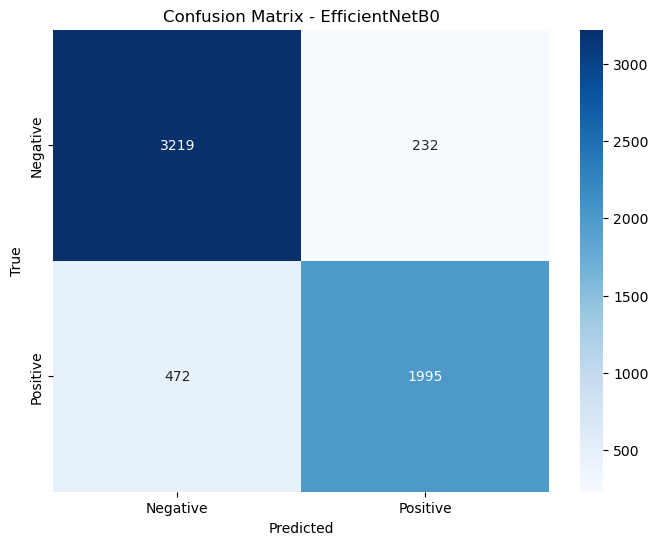

In [16]:
# Predict on test data
y_pred_resnet = resnet_model.predict(test_images)
y_pred_resnet = np.round(y_pred_resnet).flatten()
y_pred_effnet = effnet_model.predict(test_images)
y_pred_effnet = np.round(y_pred_effnet).flatten()
y_true = test_df['label'].values
# Classification report
print("\nClassification Report for ResNet50:")
print(classification_report(y_true, y_pred_resnet, target_names=["Negative", "Positive"]))
print("\nClassification Report for EfficientNetB0:")
print(classification_report(y_true, y_pred_effnet, target_names=["Negative", "Positive"]))
# ROC AUC Score
resnet_auc = roc_auc_score(y_true, y_pred_resnet)
effnet_auc = roc_auc_score(y_true, y_pred_effnet)
print(f"ResNet50 ROC AUC Score: {resnet_auc:.4f}")
print(f"EfficientNetB0 ROC AUC Score: {effnet_auc:.4f}")    
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
plot_confusion_matrix(y_true, y_pred_resnet, "ResNet50")
plot_confusion_matrix(y_true, y_pred_effnet, "EfficientNetB0")

### Training History

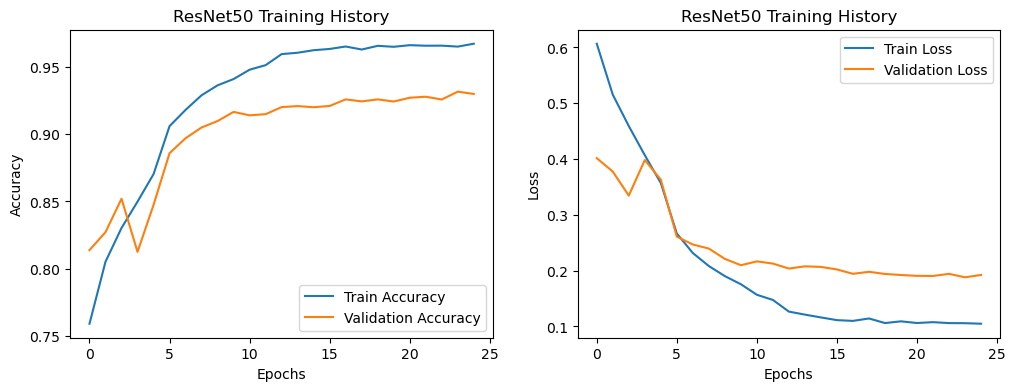

In [19]:
# Plot training history for ResNet50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

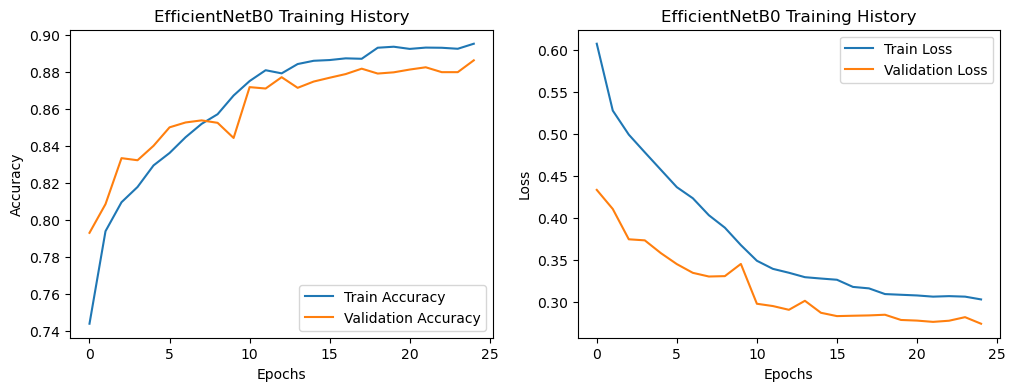

In [20]:
# Plot training history for EfficientNetB0
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')    
plt.plot(history_effnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_effnet.history['loss'], label='Train Loss')
plt.plot(history_effnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:

# Save training history
history_df = pd.DataFrame({
    'epoch': range(1, epochs + 1),
    'resnet_train_loss': history_resnet.history['loss'],
    'resnet_val_loss': history_resnet.history['val_loss'],
    'resnet_train_accuracy': history_resnet.history['accuracy'],
    'resnet_val_accuracy': history_resnet.history['val_accuracy'],
    'effnet_train_loss': history_effnet.history['loss'],
    'effnet_val_loss': history_effnet.history['val_loss'],
    'effnet_train_accuracy': history_effnet.history['accuracy'],
    'effnet_val_accuracy': history_effnet.history['val_accuracy']
})
history_df.to_csv("training_history.csv", index=False)
# Load training history
loaded_history_df = pd.read_csv("training_history.csv")

### Visualization with GradCam

conv5_block3_out


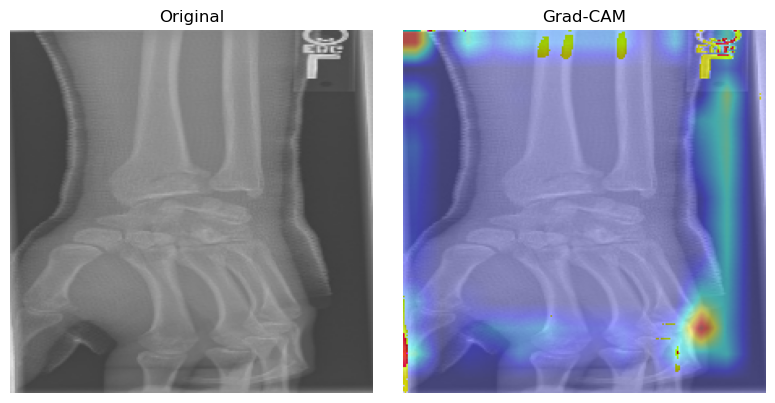

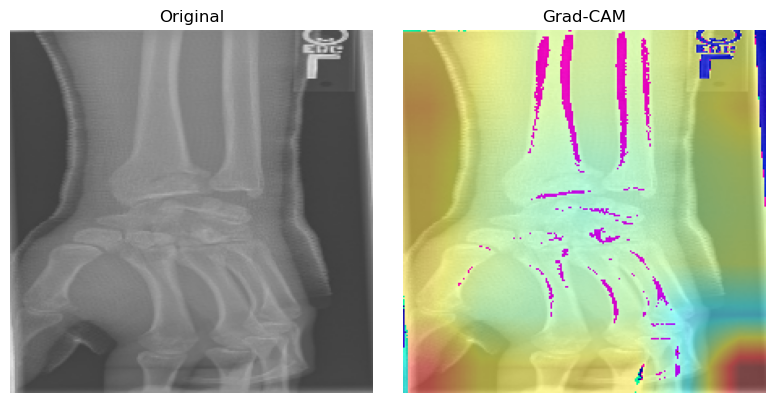

In [ ]:
#TODO 
from tensorflow.keras.preprocessing import image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(img_path, model, last_conv_layer_name):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image (again) for overlay
    img_original = cv2.imread(img_path)
    img_original = cv2.resize(img_original, (224, 224))
    heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = heatmap_colored * 0.4 + img_original
    superimposed_img = np.uint8(superimposed_img)

    # Show image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for layer in resnet_model.layers[::-1]:
    if 'conv' in layer.name:
        print(layer.name)
        break

# overlay_heatmap_on_image(test_df['path'].iloc[500], resnet_model, "conv5_block3_out")
overlay_heatmap_on_image(test_df['path'].iloc[500], resnet_model, "conv4_block6_out")

overlay_heatmap_on_image(test_df['path'].iloc[500], effnet_model, "top_conv")
